In [12]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2

folder_path = "test_cases"

In [13]:
# Function to plot histogram
def plot_histogram(image):
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    plt.plot(hist)
    plt.title("Histogram")
    plt.xlabel("Pixel value")
    plt.ylabel("Frequency")
    plt.show()


# Function to print histogram values
def unique_pixel_values(image):
    flattened_image = image.ravel()
    unique_values, counts = np.unique(flattened_image, return_counts=True)
    pixel_counts = dict(zip(unique_values, counts))
    return pixel_counts


def salt_pepper_fix(img):
    _, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)

    kernel = np.ones((9, 9), np.uint8)
    denoised_image = cv2.medianBlur(img, ksize=15)
    denoised_image = cv2.morphologyEx(denoised_image, cv2.MORPH_CLOSE, kernel)
    kernel_size = (81, 81)
    denoised_image = cv2.GaussianBlur(denoised_image, kernel_size, sigmaX=0)
    _, denoised_image = cv2.threshold(
        denoised_image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU
    )
    return denoised_image

In [14]:
def correct_skew_small(image):
    # Apply Canny edge detection to find contours
    edges = cv2.Canny(image, 50, 150, apertureSize=3)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour (assumed to be the QR code)
    max_contour = max(contours, key=cv2.contourArea)

    # Approximate the polygonal curve of the contour
    epsilon = 0.02 * cv2.arcLength(max_contour, True)
    approx = cv2.approxPolyDP(max_contour, epsilon, True)

    # Check if the contour is a quadrilateral (4 vertices)
    if len(approx) == 4:
        # Reshape the vertices of the quadrilateral
        rect = np.zeros((4, 2), dtype=np.float32)
        for i in range(4):
            rect[i] = approx[i][0]

        # Define the target square shape (assuming the QR code is square)
        target_shape = np.array(
            [[0, 0], [300, 0], [300, 300], [0, 300]], dtype=np.float32
        )

        # Compute the perspective transformation matrix
        matrix = cv2.getPerspectiveTransform(rect, target_shape)

        # Apply the perspective transformation to correct skew
        corrected_image = cv2.warpPerspective(image, matrix, (300, 300))
        return corrected_image
    else:
        return image  # Return original image if contour is not a quadrilateral


def correct_skew_qr(image):
    # Apply Canny edge detection to find contours
    edges = cv2.Canny(image, 50, 150, apertureSize=3)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour (assumed to be a locator box)
    max_contour = max(contours, key=cv2.contourArea)

    # Approximate the polygonal curve of the contour
    epsilon = 0.02 * cv2.arcLength(max_contour, True)
    approx = cv2.approxPolyDP(max_contour, epsilon, True)

    # Check if the contour is a quadrilateral (4 vertices)
    if len(approx) == 4:
        # Reshape the vertices of the quadrilateral
        rect = np.zeros((4, 2), dtype=np.float32)
        for i in range(4):
            rect[i] = approx[i][0]

        # Define the target square shape (assuming the QR code is square)
        target_shape = np.array(
            [[0, 0], [1012, 0], [1012, 1012], [0, 1012]], dtype=np.float32
        )

        # Compute the perspective transformation matrix based on the locator box
        matrix = cv2.getPerspectiveTransform(rect, target_shape)

        # Apply the perspective transformation to correct skew for the entire image
        corrected_image = cv2.warpPerspective(image, matrix, (1012, 1012))
        return corrected_image
    else:
        return image  # Return original image if contour is not a quadrilateral


def rotate_if_tilted(image):
    # Step 1: Edge Detection using Canny edge detector
    edges = cv2.Canny(image, 50, 150, apertureSize=3)

    # Step 2: Apply Hough Transform to detect lines
    lines = cv2.HoughLines(edges, rho=1, theta=np.pi / 180, threshold=100)

    if lines is not None:
        # Calculate angles of detected lines and filter out lines with extreme angles
        angles = []
        for line in lines:
            rho, theta = line[0]
            angle = np.degrees(theta)
            angles.append(angle)

        # Filter out lines based on angle threshold (e.g., exclude lines with extreme angles)
        filtered_angles = [angle for angle in angles if abs(angle) < 90]

        if filtered_angles:
            # Compute the median angle of remaining lines
            rotation_angle = np.median(filtered_angles)

            # Check if rotation angle is significant
            if abs(rotation_angle) > 5:  # Adjust threshold as needed
                if abs(rotation_angle) > 45:
                    rotation_angle = abs(rotation_angle - 90)
                print("Estimated Rotation Angle:", rotation_angle)
                # Rotate the image to make the QR code horizontal
                height, width = image.shape[:2]
                rotation_center = (width // 2, height // 2)  # Center of the image
                rotation_matrix = cv2.getRotationMatrix2D(
                    rotation_center, -rotation_angle, 1
                )

                # Apply rotation to the image (with white background)
                rotated_image = cv2.warpAffine(
                    image,
                    rotation_matrix,
                    (width, height),
                    flags=cv2.INTER_LINEAR,
                    borderMode=cv2.BORDER_CONSTANT,
                    borderValue=255,
                )

                return rotated_image
            else:
                return image  # No significant rotation needed
        else:
            return image  # Return original image
    else:
        return image  # Return original image


def rotate_image(image):
    # dilate to isolate black squares
    custom_kernel_size = 105
    custom_kernel = np.ones((custom_kernel_size, custom_kernel_size), dtype=np.uint8)
    temp_img = cv2.dilate(image, custom_kernel, iterations=1)

    # Load the image in grayscale and apply thresholding to create a binary image
    _, binary = cv2.threshold(temp_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Perform connected component analysis (CCA) to label connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        binary, connectivity=8
    )

    # loop to check on orientation
    rotation_flags = [0, 0, 0, 0]
    for i in range(1, num_labels):  # Skip the background label (0)
        x, y, _, _, _ = stats[i]
        if x < image.shape[0] / 2 and y < image.shape[0] / 2:
            rotation_flags[0] = 1
        elif x > image.shape[0] / 2 and y < image.shape[0] / 2:
            rotation_flags[1] = 1
        elif x < image.shape[0] / 2 and y > image.shape[0] / 2:
            rotation_flags[2] = 1
        elif x > image.shape[0] / 2 and y > image.shape[0] / 2:
            rotation_flags[3] = 1

    # check orientation and do optimal rotation movements
    if rotation_flags == [1, 1, 1, 0]:
        rotated_image = image
    elif rotation_flags == [1, 0, 1, 1]:
        rotated_image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    elif rotation_flags == [0, 1, 1, 1]:
        rotated_image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        rotated_image = cv2.rotate(rotated_image, cv2.ROTATE_90_CLOCKWISE)
    elif rotation_flags == [1, 1, 0, 1]:
        rotated_image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    else:
        rotated_image = image

    return rotated_image

In [15]:
def detect_locator_boxes(image):
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Detect edges using Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(
        edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # Initialize list to store bounding boxes of locator boxes
    locator_boxes = []

    # Iterate through the contours and find the bounding box of each locator box
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 1000:  # Adjust threshold as needed
            x, y, w, h = cv2.boundingRect(contour)
            locator_boxes.append((x, y, w, h))

    return locator_boxes


def expand_to_qr_code(image, locator_boxes):
    # Calculate the bounding box that encompasses all three locator patterns
    x_min = min(box[0] for box in locator_boxes)
    y_min = min(box[1] for box in locator_boxes)
    x_max = max(box[0] + box[2] for box in locator_boxes)
    y_max = max(box[1] + box[3] for box in locator_boxes)

    # Calculate the size of the expanded bounding box
    qr_code_width = x_max - x_min
    qr_code_height = y_max - y_min

    # Return the expanded bounding box
    return (x_min, y_min, qr_code_width, qr_code_height)

Case 1 {0: 445951, 255: 578193}
Case 2 {0: 410487, 255: 613657}
Case 3 {0: 442167, 255: 581977}
Case 4 {0: 457436, 255: 566708}
Case 5 {0: 492625, 255: 531519}
Case 6 {0: 262126, 255: 762018}
Case 7 {0: 383917, 255: 640227}
Case 8 {0: 405278, 255: 618866}
Case 9 {0: 352077, 255: 672067}
Case 10 {0: 411083, 255: 613061}
Case 11 {0: 233272, 255: 790872}
Case 12 {0: 475934, 255: 548210}
Case 13 {0: 385425, 255: 638719}
Case 14 {0: 9537, 255: 990463}
Case 15 {0: 19228, 255: 89672}
Case 16 {0: 484805, 255: 545420}


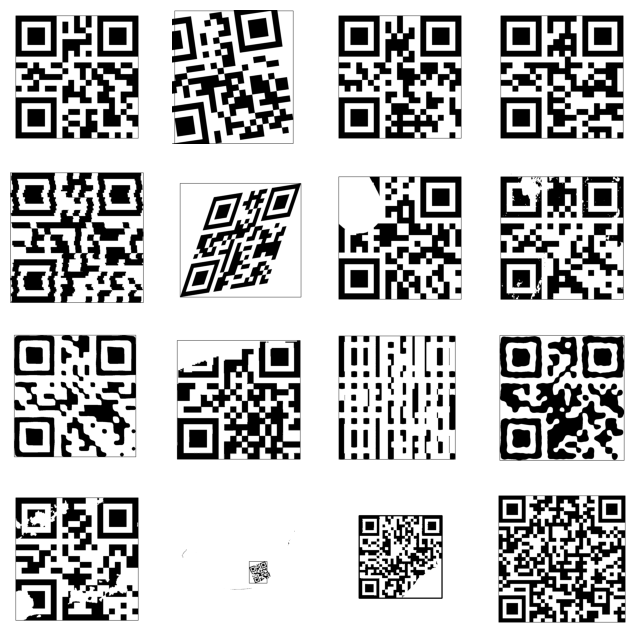

In [16]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, filename in enumerate(os.listdir(folder_path)):
    if i >= 16:
        break

    image_path = os.path.join(folder_path, filename)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # check for anomaly sin wave frequency on all images then remove it from all images

    # initial thresholding and histogram equalization
    _, image_new = cv2.threshold(image, 64, 255, cv2.THRESH_BINARY)
    image_new = cv2.equalizeHist(image_new)
    # if new image is corrupted (all black or all white), keep original for now
    hist_values = unique_pixel_values(image_new)
    if len(hist_values) == 1:
        image_new = image

    # if black pixels are more than white pixels, invert image and threshold
    hist_values = unique_pixel_values(image_new)
    if 0 in hist_values and 255 in hist_values:
        if hist_values[0] > hist_values[255]:
            image_new = 255 - image
            _, image_new = cv2.threshold(image_new, 200, 255, cv2.THRESH_BINARY)

    hist_values = unique_pixel_values(image_new)
    sum_of_keys = sum(key for key in hist_values)

    # check for very black images, NOT GENERIC!!!
    if sum_of_keys < 100:
        increased_brightness = cv2.add(image, 150)
        equalized_image = cv2.equalizeHist(increased_brightness)
        _, image_new = cv2.threshold(equalized_image, 100, 255, cv2.THRESH_BINARY)

    # check for very bright images, NOT GENERIC!!!
    if sum_of_keys > 1000:
        subtracted_image = np.clip(image - 170, 0, 255).astype(np.uint8)
        equalized_image = cv2.equalizeHist(subtracted_image)
        _, image_new = cv2.threshold(equalized_image, 127, 255, cv2.THRESH_BINARY)

    # do second thresolding to make all images at 0-255
    hist_values = unique_pixel_values(image_new)
    if 0 not in hist_values and 255 not in hist_values:
        keys_average = sum_of_keys / len(hist_values)
        equalized_image = cv2.equalizeHist(image_new)
        _, image_new = cv2.threshold(
            equalized_image, keys_average, 255, cv2.THRESH_BINARY
        )

    # check first 5 pixels on first row to detect salt and pepper
    hist_values = unique_pixel_values(image_new[0][0:5])
    if len(hist_values) > 1:
        image_new = salt_pepper_fix(image)

    ################################################################

    # rotate images that has clear 3 locator boxes
    image_new = rotate_image(image_new)

    # check for tilt and fix
    # image_new = rotate_if_tilted(image_new)

    # Detect all three locator boxes
    locator_boxes = detect_locator_boxes(image_new)

    if locator_boxes:
        # Expand to encompass the entire QR code
        expanded_box = expand_to_qr_code(image_new, locator_boxes)

        # Draw the expanded bounding box on the image (optional)
        x, y, w, h = expanded_box
        cv2.rectangle(image_new, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Plot the image in the corresponding subplot
    row = i // 4
    col = i % 4
    axes[row, col].axis("off")
    axes[row, col].imshow(image_new, cmap="gray")

    hist_values = unique_pixel_values(image_new)
    print(f"Case {i+1}", hist_values)

plt.show()